## Data Preprocessing

In [2]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#! kaggle competitions download -c skku-2023-1-machine-learning-first-project

In [25]:
bulk_files = glob.glob('./train/bulk*')
inter_files = glob.glob('./train/interactive*')
video_files = glob.glob('./train/video*')
web_files = glob.glob('./train/web*')

In [26]:
def preprocessing(df):
    # POSIX time to %Y/%m/%d %H:%M:%S format
    df.time = df.time.astype(int)
    df.time = pd.to_datetime(df.time , unit='s')
    df.time = df.time.dt.strftime('%Y/%m/%d %H:%M:%S')

    grouped = df.groupby(['time', 'ip_dst']).agg({'data_len': 'count'})
    grouped = grouped[grouped.groupby('ip_dst')['data_len'].transform('size') > 40]
    
    plt.figure(figsize=(5,3))
    plt.plot(grouped.sort_values(['ip_dst','time']).data_len.values)
    plt.show()
    grouped.reset_index(inplace=True)
    
    ip_groups = grouped.groupby('ip_dst')
    wind_df = pd.DataFrame()
    # slide windowing, size 11 
    for ip, group in ip_groups :
        temp = pd.DataFrame()
        group = group.sort_values('time')
        for i in range(11):
            temp[i] = group['data_len'].shift(i)
        wind_df = wind_df.append(temp).loc[::-1]
    
    wind_df.dropna(inplace=True)
    wind_df.reset_index(drop=True, inplace=True)
    return wind_df


In [ ]:
df = pd.DataFrame()
for video_file in video_files :
    temp = pd.read_csv(video_file)
    df = df.append(temp)
print(len(df))
video_df = preprocessing(df)

df = pd.DataFrame()
for inter_file in inter_files :
    temp = pd.read_csv(inter_file)
    df = df.append(temp)
print(len(df))
inter_df = preprocessing(df)

df = pd.DataFrame()
for bulk_file in bulk_files :
    temp = pd.read_csv(bulk_file)
    df = df.append(temp)
print(len(df))
bulk_df = preprocessing(df)

df = pd.DataFrame()
for web_file in web_files :
    temp = pd.read_csv(web_file)
    df = df.append(temp)
print(len(df))
web_df = preprocessing(df)

In [28]:
bulk_df_re = bulk_df[bulk_df.sum(axis=1) > 20]
video_df_re = video_df[video_df.sum(axis=1) > 20]
web_df_re = web_df[web_df.sum(axis=1) > 20]
bulk_df_re.reset_index(inplace=True)
web_df_re.reset_index(inplace=True)
video_df_re.reset_index(inplace=True)

In [ ]:
bulk_df_re['y'] = pd.Series([1]*len(bulk_df_re)) # bulk : 1
video_df_re['y'] = pd.Series([2]*len(video_df_re)) # video : 2
web_df_re['y'] = pd.Series([3]*len(web_df_re)) # web : 3
inter_df['y'] = pd.Series([0]*len(inter_df)) # inter : 0

print(len(bulk_df),len(video_df),len(web_df),len(inter_df)) 
# 학습 데이터의 크기 차이가 너무 큰 상황

In [30]:
train_data = pd.concat([bulk_df_re, video_df_re, inter_df, web_df_re], axis=0, ignore_index=True).iloc[:,1:13]
train_data.columns = [f'(t-{10-i})'for i in range(0, 11)]+['y']
print(len(train_data))
train_data.to_csv("./train_data.csv",index=False)

14895


## Data re-sampling methods

In [3]:
train_data = pd.read_csv('./train_data.csv')
X = train_data.iloc[:, 0:11]
y = train_data.iloc[:, 11]

In [7]:
# ! pip install imblearn
from imblearn.under_sampling import *
X_cc, y_cc = ClusterCentroids(sampling_strategy={0:10}).fit_resample(X, y)
X_os, y_os = OneSidedSelection().fit_resample(X, y)

from imblearn.over_sampling import *
X_sm, y_sm = SMOTE(sampling_strategy='minority').fit_resample(X, y)
X_ada, y_ada = ADASYN().fit_resample(X, y)

from imblearn.combine import *
X_samp, Y_samp = SMOTEENN().fit_resample(X, y)
X_smtk, Y_smtk = SMOTETomek().fit_resample(X, y)

In [36]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

svm = svm.SVC()
cv_results_1 = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
cv_results_2 = cross_val_score(svm, X_sm, y_sm, cv=5, scoring='accuracy')
cv_results_3 = cross_val_score(svm, X_ada, y_ada, cv=5, scoring='accuracy')
cv_results_4 = cross_val_score(svm, X_cc, y_cc, cv=5, scoring='accuracy')
cv_results_5 = cross_val_score(svm, X_os, y_os, cv=5, scoring='accuracy')
cv_results_6 = cross_val_score(svm, X_samp, Y_samp, cv=5, scoring='accuracy')
cv_results_7 = cross_val_score(svm, X_smtk, Y_smtk, cv=5, scoring='accuracy')
print(cv_results_1.mean(), cv_results_1.std())
print(cv_results_2.mean(), cv_results_2.std()) 
print(cv_results_3.mean(), cv_results_3.std())
print(cv_results_4.mean(), cv_results_4.std())
print(cv_results_5.mean(), cv_results_5.std())
print(cv_results_6.mean(), cv_results_4.std())
print(cv_results_7.mean(), cv_results_5.std())

0.8489425981873111 0.035222741563141126
0.7645735921082047 0.004179863955928422
0.5536887723337698 0.11674986218611605
0.8640862472850872 0.09043893520799233
0.8490552564903862 0.033796805130622165
0.7167644726407614 0.09043893520799233
0.7176905299563628 0.033796805130622165


In [9]:
# Conversion data to numpy array and calling test data
X_train_data = X.values
y_train_data = y.values
test_data = pd.read_csv("./test.csv").values

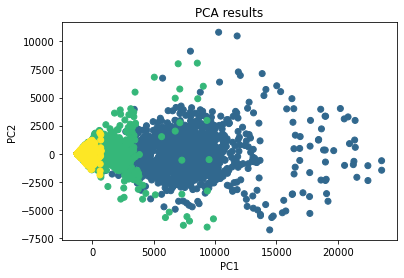

In [10]:
# 시각화를 위한 PCA
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_data)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_data)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA results')
plt.show()

## Model Training, Test and evaluation

In [88]:
class Multiclass_SVM :
      def __init__(self, C=1,max_iter=1000):
            self.C = C
            self.max_iter = max_iter
                  
      def fit(self, X, y):
            self.classes = np.unique(y)
            self.n_classes = len(self.classes)
            self.classifiers =[]
        
            # one-hot encoding 진행
            Y_hot = self.one_hot(y)
            
            # one-vs-one approach, 총 m(m-1)/2 번의 Binary Classification을 진행하고 사용한 모델을 저장한다.
            # voting을 통하여 가장 많이 뽑힌 class로 분류를 진행. 느린 방식이지만 one vs rest approach보다 더 안정적인 성능을 기대할 수 있다.
            for i in range(self.n_classes):
                  for j in range(i+1, self.n_classes):
                        print(f"class {i}, {j} Binary SVM")
                        # 필요한 class의 데이터만 뽑아내어 Binary SVC에 넣어 fitting 진행.
                        Xi = X[(y==self.classes[i]) | (y==self.classes[j])] # numpy의 boolean operator "|" 사용하여 multiclass분류 진행
                        Yi = Y_hot[(y == self.classes[i]) | (y == self.classes[j]), :][:, [i,j]]
                        svm = SVM(self.C, self.max_iter)
                        svm.fit(Xi, np.argmax(Yi, axis=1) * 2 - 1) # class label을 -1, 1로 변경하고, vector형태로 변경한 뒤 binary SVM fitting 실시
                        self.classifiers.append((svm, i, j))
                        
      def one_hot(self, y):
            # One-hot encoding. One-vs-one approach를 위해 y를 one-hot encoding 하여 matrix형태로 만들고 필요한 class에 해당하는 행만 추출하여 사용할 수 있도록 한다.
            Y_hot = np.zeros((len(y), self.n_classes))
            for i, c in enumerate(self.classes):
                  Y_hot[y == c, i] = 1
            return Y_hot

      def predict(self, X):
            votes = np.zeros((len(X), self.n_classes))
            # 저장해둔 모델을 통해서 prediction을 진행하고, 각 class에 voting 진행.
            for svm, i, j in self.classifiers :
                  pred = svm.predict(X)
                  votes[pred == 1, i] += 1
                  votes[pred == -1, j] += 1
                  
            # 최종적으로 가장 많은 vote가 있는 class로 분류
            return self.classes[np.argmax(votes, axis=1)] 

In [95]:
import numpy as np
from scipy.optimize import minimize

class SVM:
    def __init__(self, C=1, max_iter=1000):
        self.C = C
        self.max_iter = max_iter
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
    
    def kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def fit(self, X, y):
        n, n_features = X.shape
        
        # gamma값의 계산. RBF kernel, gaussian kernel의 r값은 원래 1/sigma^2으로써, 그대로 이를 계산하여 사용할 수 있다.
        # 다만 분산의 값이 작아질 수록 복잡한 decision boundary를 형성할 수 있고, 함수의 복잡도를 tuning할 수 있기 때문에 
        # 직접 지정하도록 할 수도 있지만 parameter tuning을 진행하지 않았다.
        self.gamma = 1 / (n_features * np.var(X))

        # Objective Function의 정의. sum(α) - 0.5 * sum(i)sum(j)αi*αj*yi*yj*kernel(xi, xj)
        # minimization problem으로 변경하기 위하여 부호를 바꾸어 표기.
        def objective(alphas):
            return 0.5 * np.sum(alphas * alphas * y * y[:, np.newaxis] * np.array([[self.kernel(X[i], X[j]) for j in range(n)] for i in range(n)])) - np.sum(alphas)
       
        # constraints : 최적화 문제에서 사용되는 제약 조건. SVM에서는 0 < sum(α) < C 이어야 한다는 제약 조건.
        def constraint(alphas):
            return np.sum(alphas * y)

        # optimizer를 위한 bound 설정 : α값이 가질 수 있는 범위의 설정. 0부터 C까지의 범위 설정
        # C는 Regularization cost로서 Margin의 넓이와 Margin에서 벗어나는 값들의 Penalty에 대하여 Trade-off를 조절해주는 역할을 함.
        bounds = [(0, self.C) for i in range(n)]

        # optimizer의 초기 α값 설정
        init_guess = np.zeros(n)

        # optimzer의 최대 반복 횟수 설정
        options = {'maxiter': self.max_iter}
        constraints = {'type': 'eq', 'fun': constraint}
        
        # scipy 패키지의 minimize함수 사용하여 optimization진행
        res = minimize(objective, init_guess, bounds=bounds, constraints=constraints, options=options)

        # 최적화된 alpha값을 저장.
        self.alphas = res.x

        # KKT 조건의 고려. 모든 x값에 대하여 y*(w*x+b)-1+ξ≥0, α*ξ= 0 을 만족하고, alpha값이 0과 C사이의 값을 가지도록 한다.
        # 위 조건은 모든 x에 대하여 성립해야 하기 때문에 optimization 과정에서는 모든 x값에 대하여 alpha값을 계산한 다음
        # KKT 조건을 만족하는 alpha값을 추려내고, support vector를 뽑아낸다.
        # 그 다음 support vector만을 이용하여 decision boundary를 계산한다.
        threshold = 1e-5 # threshold의 설정
        self.support_vectors = X[self.alphas > threshold]
        self.support_vector_labels = y[self.alphas > threshold]

    def predict(self, X):
        # 학습된 alpha값을 통해서 input data에 대한 분류 결과 return
        predictions = []
        for sample in X:
            prediction = 0
            for i in range(len(self.support_vectors)):
                prediction += self.alphas[i] * self.support_vector_labels[i] * self.kernel(sample, self.support_vectors[i])
            predictions.append(np.sign(prediction))

        return np.array(predictions)

# 본 코드는 https://hoonst.github.io/2021/01/13/SVM-KKT-Conditions/ 등 다양한 웹 포스트에서 참고한 공식들을 바탕으로 구현되었습니다.
# 정확한 결과가 나오지 않을 수 있으며, 계산 과정에서 정확하지 않거나 구현이 잘못된 부분이 있을 수 있습니다.

In [ ]:
# Binary Classificaiton 작동확인 / toy dataset
X = np.random.randn(100, 2)
y = np.where(X[:, 0] + X[:, 1] > 0, 1, -1)
X_tr, y_tr, X_te, Y_te = 
svm = SVM()
svm.fit(X, y)

In [ ]:
svm = Multiclass_SVM(max_iter=100)
svm.fit(X_train_data, y_train_data)

## load test dataset and make answer sheet

In [13]:
pred = svm.predict(test_data)
ans = pd.DataFrame(pred).reset_index().rename(columns={"index":"id", 0:"type"})
ans.id = ans.id + 1
ans.to_csv("./answer.csv", index=False)